In [38]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import gym
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [39]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=16):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(input_size, n_hidden, bias=True)
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(n_hidden, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x


def get_action(net, obs):
    return net(torch.from_numpy(obs.copy()).float()).detach().numpy().argmax()

def evaluate(net):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = get_action(net, obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward

def fitness_function(net, episodes=1):
    return np.mean([evaluate(net) for _ in range(episodes)])

def compute_fitness(population):
    return np.array([fitness_function(individual) for individual in population])

def get_fittest(population, fitness_scores):
    return population[fitness_scores.argmax()]

In [40]:
def behaviour(net):
    obs = env.reset()
    done = False
    while not done:
        action = get_action(net, obs)
        obs, reward, done, _ = env.step(action)
    return obs

def similarity(net1, net2):
    b1, b2 = behaviour(net1), behaviour(net2)
    return np.sum((b1 - b2)**2)

def compute_novelty(population, k=3):
    distances = []
    n = len(population)
    for i in range(n):
        distance_i = sorted([similarity(population[i], population[j]) for j in range(n) if i != j])[:k]
        distances.append(np.mean(distance_i))
    return distances

def get_novel_subpopulation(population, novelty_scores):
    return population[novelty_scores.argmax()]

def select_most_novel(population, novelty_scores, k=0.5):
    return population[np.argsort(novelty_scores)[-int(len(population) * k):]]

In [41]:
import copy

def perform_reproduction(subpopulation):
    num_children = population_size - len(subpopulation)
    parents = np.random.choice(subpopulation, num_children)
    return np.append(subpopulation, [copy.deepcopy(p) for p in parents], axis=0)

In [42]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

def get_params(net):
    return parameters_to_vector(net.parameters())

def mutate_params(net, sigma=0.1):
    mutated_params = get_params(net) + torch.normal(0, sigma, size=get_params(net).data.shape)
    vector_to_parameters(mutated_params, net.parameters())

def perform_mutation(population, sigma=0.1):
    for individual in population:
        mutate_params(individual, sigma=0.1)
    return population

In [43]:
# Novelty Search hyperparameters
population_size = 20
num_generations = 100
top_k = 0.2
mutation_sigma = 0.1
k_nearest = 3

# CartPole environment initialisation
env = gym.make('CartPole-v1')

# Neural network hyperparameters
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
n_hidden = 16

# Process 1: Generate the initial population.
population = np.array([Net(input_size, output_size, n_hidden) for _ in range(population_size)])

# Misc: Experimental tracking
scores = []
fittests = []

with open("Cartpole_NS_train_scores.csv", "w") as csvfile:
    header = ["generation", "average fitness", "maximum fitness"]
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)

    for gen in range(num_generations):

      # Process 2: Compute the novelty of individuals with respect to closest neighbours in the population.
        novelty_scores = compute_novelty(population, k=k_nearest)

      # Process 3: Select the most novel individuals.
        novel_subpopulation = select_most_novel(population, novelty_scores, k=top_k)

      # Misc: Experimental tracking
        fitness_scores = compute_fitness(population)
        genAvgFit = np.mean(fitness_scores)
        fittest = get_fittest(population, fitness_scores) #the fittest one of the population
        fittests.append(fittest)
        max_fitness_pop = max(fitness_scores)
        scores.append(max_fitness_pop)

        print("Generation : %3d |  Avg Fitness : %5.0f  |  Max Fitness : %5.0f  " % (gen+1, genAvgFit, max_fitness_pop))
        writer.writerow([gen+1, genAvgFit, max_fitness_pop])
        
      # Process 4: Perform reproduction between parents.
        children = perform_reproduction(novel_subpopulation)
        population = perform_mutation(children, sigma=mutation_sigma)

Generation :   1 |  Avg Fitness :    12  |  Max Fitness :    30  
Generation :   2 |  Avg Fitness :    16  |  Max Fitness :    80  
Generation :   3 |  Avg Fitness :    14  |  Max Fitness :    41  
Generation :   4 |  Avg Fitness :    18  |  Max Fitness :    49  
Generation :   5 |  Avg Fitness :    26  |  Max Fitness :   129  
Generation :   6 |  Avg Fitness :    29  |  Max Fitness :    88  
Generation :   7 |  Avg Fitness :    19  |  Max Fitness :    92  
Generation :   8 |  Avg Fitness :    30  |  Max Fitness :    89  
Generation :   9 |  Avg Fitness :    18  |  Max Fitness :    90  
Generation :  10 |  Avg Fitness :    31  |  Max Fitness :    98  
Generation :  11 |  Avg Fitness :    50  |  Max Fitness :   288  
Generation :  12 |  Avg Fitness :    64  |  Max Fitness :   364  
Generation :  13 |  Avg Fitness :    89  |  Max Fitness :   351  
Generation :  14 |  Avg Fitness :   105  |  Max Fitness :   489  
Generation :  15 |  Avg Fitness :    74  |  Max Fitness :   261  
Generation

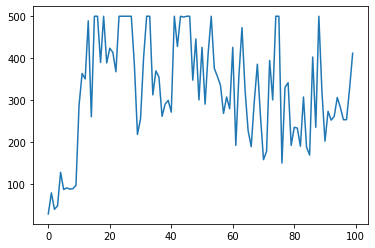

In [48]:
# Misc: Experimental tracking
plt.plot(np.arange(num_generations), scores)
plt.show()

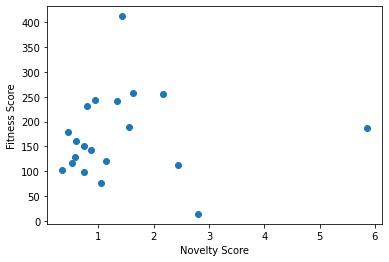

In [49]:
plt.xlabel("Novelty Score")
plt.ylabel("Fitness Score")
plt.scatter(novelty_scores, fitness_scores)
plt.show()

In [50]:
fit = np.argmax(scores) #index of fittest individual
fittest_overall = fittests[fit]

In [51]:
PLAY = 100

with open("Cartpole_NS_play_scores.csv", "w") as csvfile2:
    writer = csv.writer(csvfile2, delimiter=',')
    header = ["attempt", "score"]
    writer.writerow(header)
    
    for attempt in range(PLAY):
        obs = env.reset()
        rewards = 0
        for step in range(500):
            action = get_action(fittest_overall, obs)
            obs, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                obs = env.reset()
                break
        print("Attempt : %3d |  Score : %4.0f  " % (attempt+1, rewards) )
        writer.writerow([attempt+1, rewards])

Attempt :   1 |  Score :  499  
Attempt :   2 |  Score :  459  
Attempt :   3 |  Score :  500  
Attempt :   4 |  Score :  412  
Attempt :   5 |  Score :  342  
Attempt :   6 |  Score :  299  
Attempt :   7 |  Score :  500  
Attempt :   8 |  Score :  366  
Attempt :   9 |  Score :  464  
Attempt :  10 |  Score :  442  
Attempt :  11 |  Score :  365  
Attempt :  12 |  Score :  500  
Attempt :  13 |  Score :  419  
Attempt :  14 |  Score :  500  
Attempt :  15 |  Score :  469  
Attempt :  16 |  Score :  500  
Attempt :  17 |  Score :  442  
Attempt :  18 |  Score :  360  
Attempt :  19 |  Score :  446  
Attempt :  20 |  Score :  451  
Attempt :  21 |  Score :  500  
Attempt :  22 |  Score :  350  
Attempt :  23 |  Score :  500  
Attempt :  24 |  Score :  484  
Attempt :  25 |  Score :  410  
Attempt :  26 |  Score :  462  
Attempt :  27 |  Score :  460  
Attempt :  28 |  Score :  419  
Attempt :  29 |  Score :  425  
Attempt :  30 |  Score :  225  
Attempt :  31 |  Score :  313  
Attempt 